# Problem Statement

My friend is trading cars from overseas and selling them in Poland. He is interested in checking whether it is possible to buy cars cheaper in US, then shipping them over to Poland. 

Majority of cars he sells are Audi, BMW and Mercedes, since those are most popular used cars bought in Poland.

He would like to know what will be the price for each make and model to make his decision.

### Loading the libraries and datasets

In [16]:
# Internal Function Files
import autotrader_scraper_dealer as a
import cars_data_cleanup_functions as c

# Typical libraries :-)
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# Data pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore') 

In [36]:
audi = c.car_df_cleanup(pd.read_csv("audi_full.csv")).reset_index(drop=True)
bmw = c.car_df_cleanup(pd.read_csv("bmw_full.csv")).reset_index(drop=True)
mercedes = c.car_df_cleanup(pd.read_csv("mercedes_full.csv")).reset_index(drop=True)
audi.shape, bmw.shape, mercedes.shape
cars = pd.concat([audi, bmw, mercedes], axis=0, ignore_index=True)
cars = cars.drop_duplicates(ignore_index=True).reset_index(drop=True)
cars = cars.drop("Unnamed: 0", axis=1)

# Exploratory Data Analysis

#### There is no null values, or 0 values, or duplicates, as the scraped data from Autotrader.com has been already cleaned when loaded to the DataFrames

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24117 entries, 0 to 24116
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   model                24117 non-null  object 
 1   year                 24117 non-null  object 
 2   price                24117 non-null  int64  
 3   mileage_x            24117 non-null  int64  
 4   dealer distance      24117 non-null  int64  
 5   engine_description   24117 non-null  float64
 6   drive_type           24117 non-null  object 
 7   exterior_colour      24117 non-null  object 
 8   electronic_steering  24117 non-null  int64  
 9   wheels               24117 non-null  int64  
 10  premium_interior     24117 non-null  int64  
 11  interior_technology  24117 non-null  int64  
 12  navigation           24117 non-null  int64  
 13  driving_assist       24117 non-null  int64  
 14  lights               24117 non-null  int64  
 15  roof                 24117 non-null 

#### There clearly is big difference between 75th Percentile and Max price. There are 380 cars with price over 100k USD. We can see that out 7 models with price over 100k there is 5 very luxurious ones. We will definitely have to do data bining and assign models to different segments.

#### All cars here seems to have navig and premium lights, so I will drop both columns.

In [37]:
cars = cars.drop(["navigation", "lights"], axis=1)
cars.describe()

,price,mileage_x,dealer distance,engine_description,electronic_steering,wheels,premium_interior,interior_technology,driving_assist,roof,sound_system
count,24117.000000,24117.000000,24117.000000,24117.000000,24117.000000,24117.000000,24117.000000,24117.000000,24117.000000,24117.000000,24117.000000
mean,33379.803956,62796.222208,646.868101,2.845851,0.474479,0.079570,0.391467,0.303064,0.545839,0.317577,0.177219
std,21538.143996,34880.677436,697.516039,0.969891,0.499359,0.270633,0.488088,0.459592,0.497905,0.465544,0.381862
min,2995.000000,10.000000,1.000000,1.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19995.000000,34877.000000,108.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29250.000000,56633.000000,421.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,39495.000000,85976.000000,942.000000,3.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,450000.000000,358053.000000,4958.000000,6.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
cars[cars["price"] > 100000]

,model,year,price,mileage_x,dealer distance,engine_description,drive_type,exterior_colour,electronic_steering,wheels,premium_interior,interior_technology,driving_assist,roof,sound_system,segment
4914,Q5,2016,123456,107130,307,2.0,All wheel drive,white,0,0,0,1,0,0,0,J-low
5879,R8,2020,189990,15157,171,5.2,All wheel drive,black,0,0,0,0,0,0,0,F
5880,R8,2011,159995,15455,24,5.2,All wheel drive,black,1,1,1,1,1,0,1,F
5882,R8,2018,136900,35093,3,5.2,All wheel drive,silver,1,0,0,0,1,0,1,F
5884,R8,2020,158900,15998,18,5.2,All wheel drive,white,1,0,0,0,1,0,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23450,S-Class,2020,103500,27526,721,4.0,All wheel drive,black,1,0,1,1,1,0,0,F
23571,SL-Class,2019,104900,22577,468,5.5,2 wheel drive - rear,black,0,0,0,0,0,0,0,S
23608,SL-Class,2019,109500,17123,623,5.5,2 wheel drive - rear,silver,0,0,0,0,0,0,0,S
23709,SL-Class,2017,149900,24276,1013,6.0,2 wheel drive - rear,black,0,0,0,0,0,0,0,S


### Unnecessary data

#### Removing the single 2 wheel drive value, as it is just one.

In [38]:
cars = cars[cars["drive_type"] != "2 wheel drive"]

#### Burgundy is close to red, so it can be replaced. Removing the one green will also not affect the data.

In [39]:
cars["exterior_colour"] = cars["exterior_colour"].apply(lambda colour: "red" if colour == "burgundy" else colour)
cars = cars[cars["exterior_colour"] != "green"]

### Dealing with Outliers

#### Using Interquartile (IQR) method to detect outliers in Price

#### Dropping 4.2% of values doesn't seem a big deal, but that will remove all or nearly all luxury cars from the dataset. E.g. first 7 models with largest value counts are luxury cars. 

#### After spreading all models across respectable segments it still shows outliers.

<IPython.core.display.Javascript object>


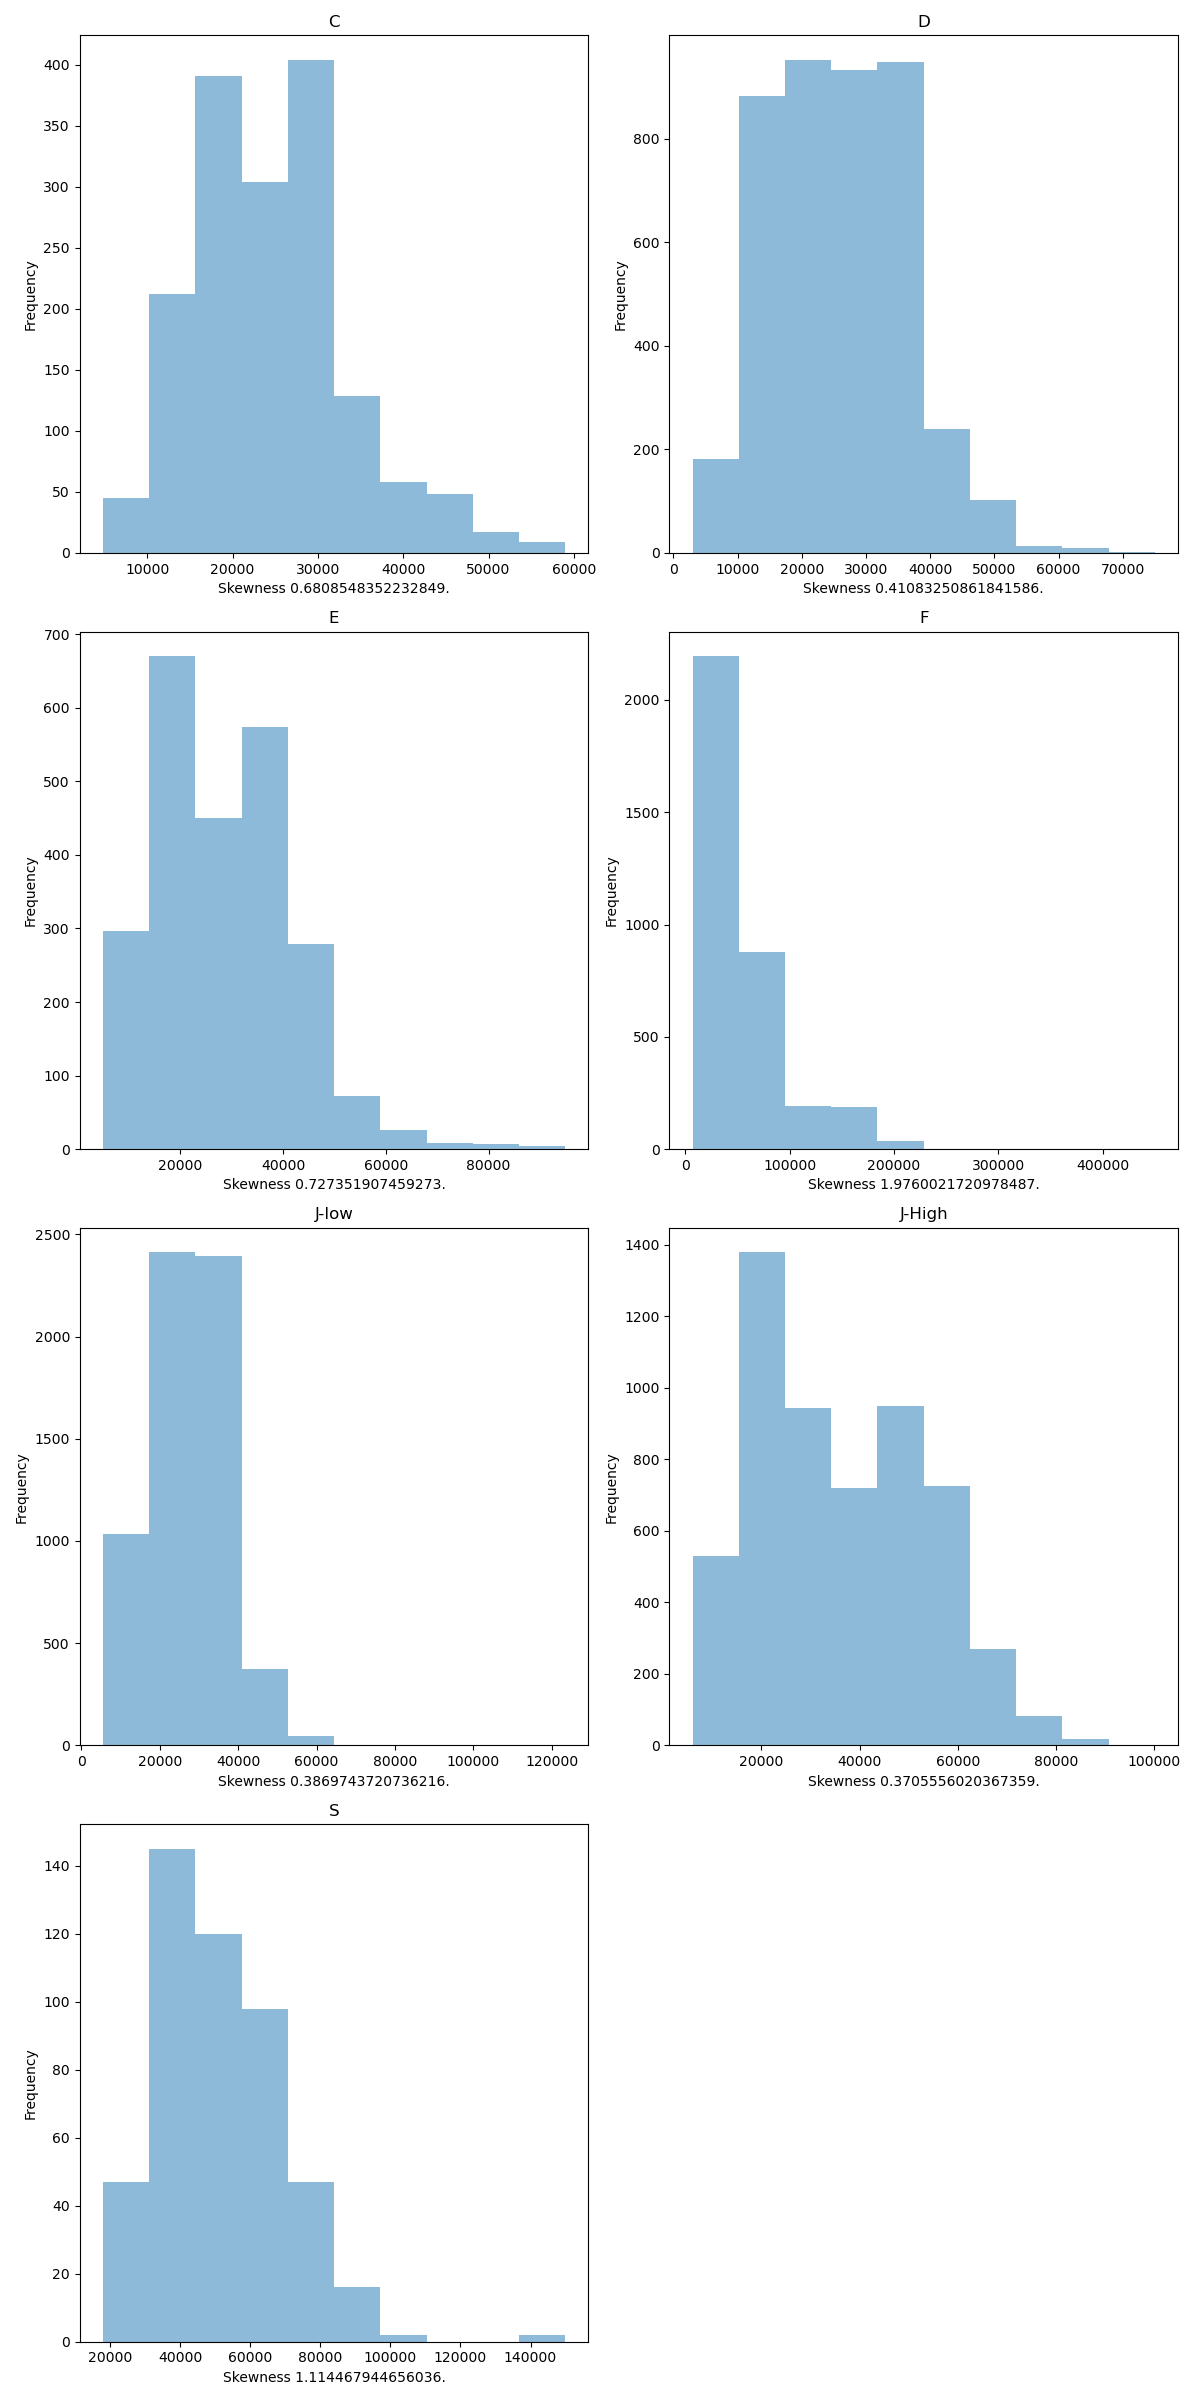

In [8]:
%matplotlib notebook

segments = cars["segment"].unique()  

num_segments = len(segments)
num_rows = num_segments // 2 + num_segments % 2 

fig, axs = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
axs = axs.flatten()

# Plot histogram for each segment
for i, segment in enumerate(segments):
    segment_data = cars[cars["segment"] == segment]  

    # Determine the subplot index
    subplot_index = i % (num_rows * 2)

    axs[subplot_index].hist(segment_data["price"], bins=10, alpha=0.5)
    axs[subplot_index].set_xlabel(f"Skewness {segment_data['price'].skew()}.")
    axs[subplot_index].set_ylabel("Frequency")
    axs[subplot_index].set_title(segment)

# Remove any unused subplots
for j in range(i + 1, num_rows * 2):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [9]:
# Function to show outliers for each segment prices

def calculate_segment_outliers(df):
    segments = df["segment"].unique()  # Get unique segments
    outliers_min_values = {}
    for segment in segments:
        segment_data = df[df["segment"] == segment]  # Filter data for the current segment
        price = segment_data["price"]
        
        q1 = price.quantile(0.25)
        q3 = price.quantile(0.75)
        iqr = q3 - q1
        threshold = 1.5
        outliers = price[(price < q1 - threshold * iqr) | (price > q3 + threshold * iqr)]
        
        outliers_min_values.update({segment:min(outliers)})
        
        #print(f"Segment: {segment}")
        #print("Outliers:")
        #print(outliers.sort_values())
        #print("---------------------")
        
    return outliers_min_values

#### There are not too many outliers, so have re-created the histograms without the outliers. Skewness looks much better now.

<IPython.core.display.Javascript object>


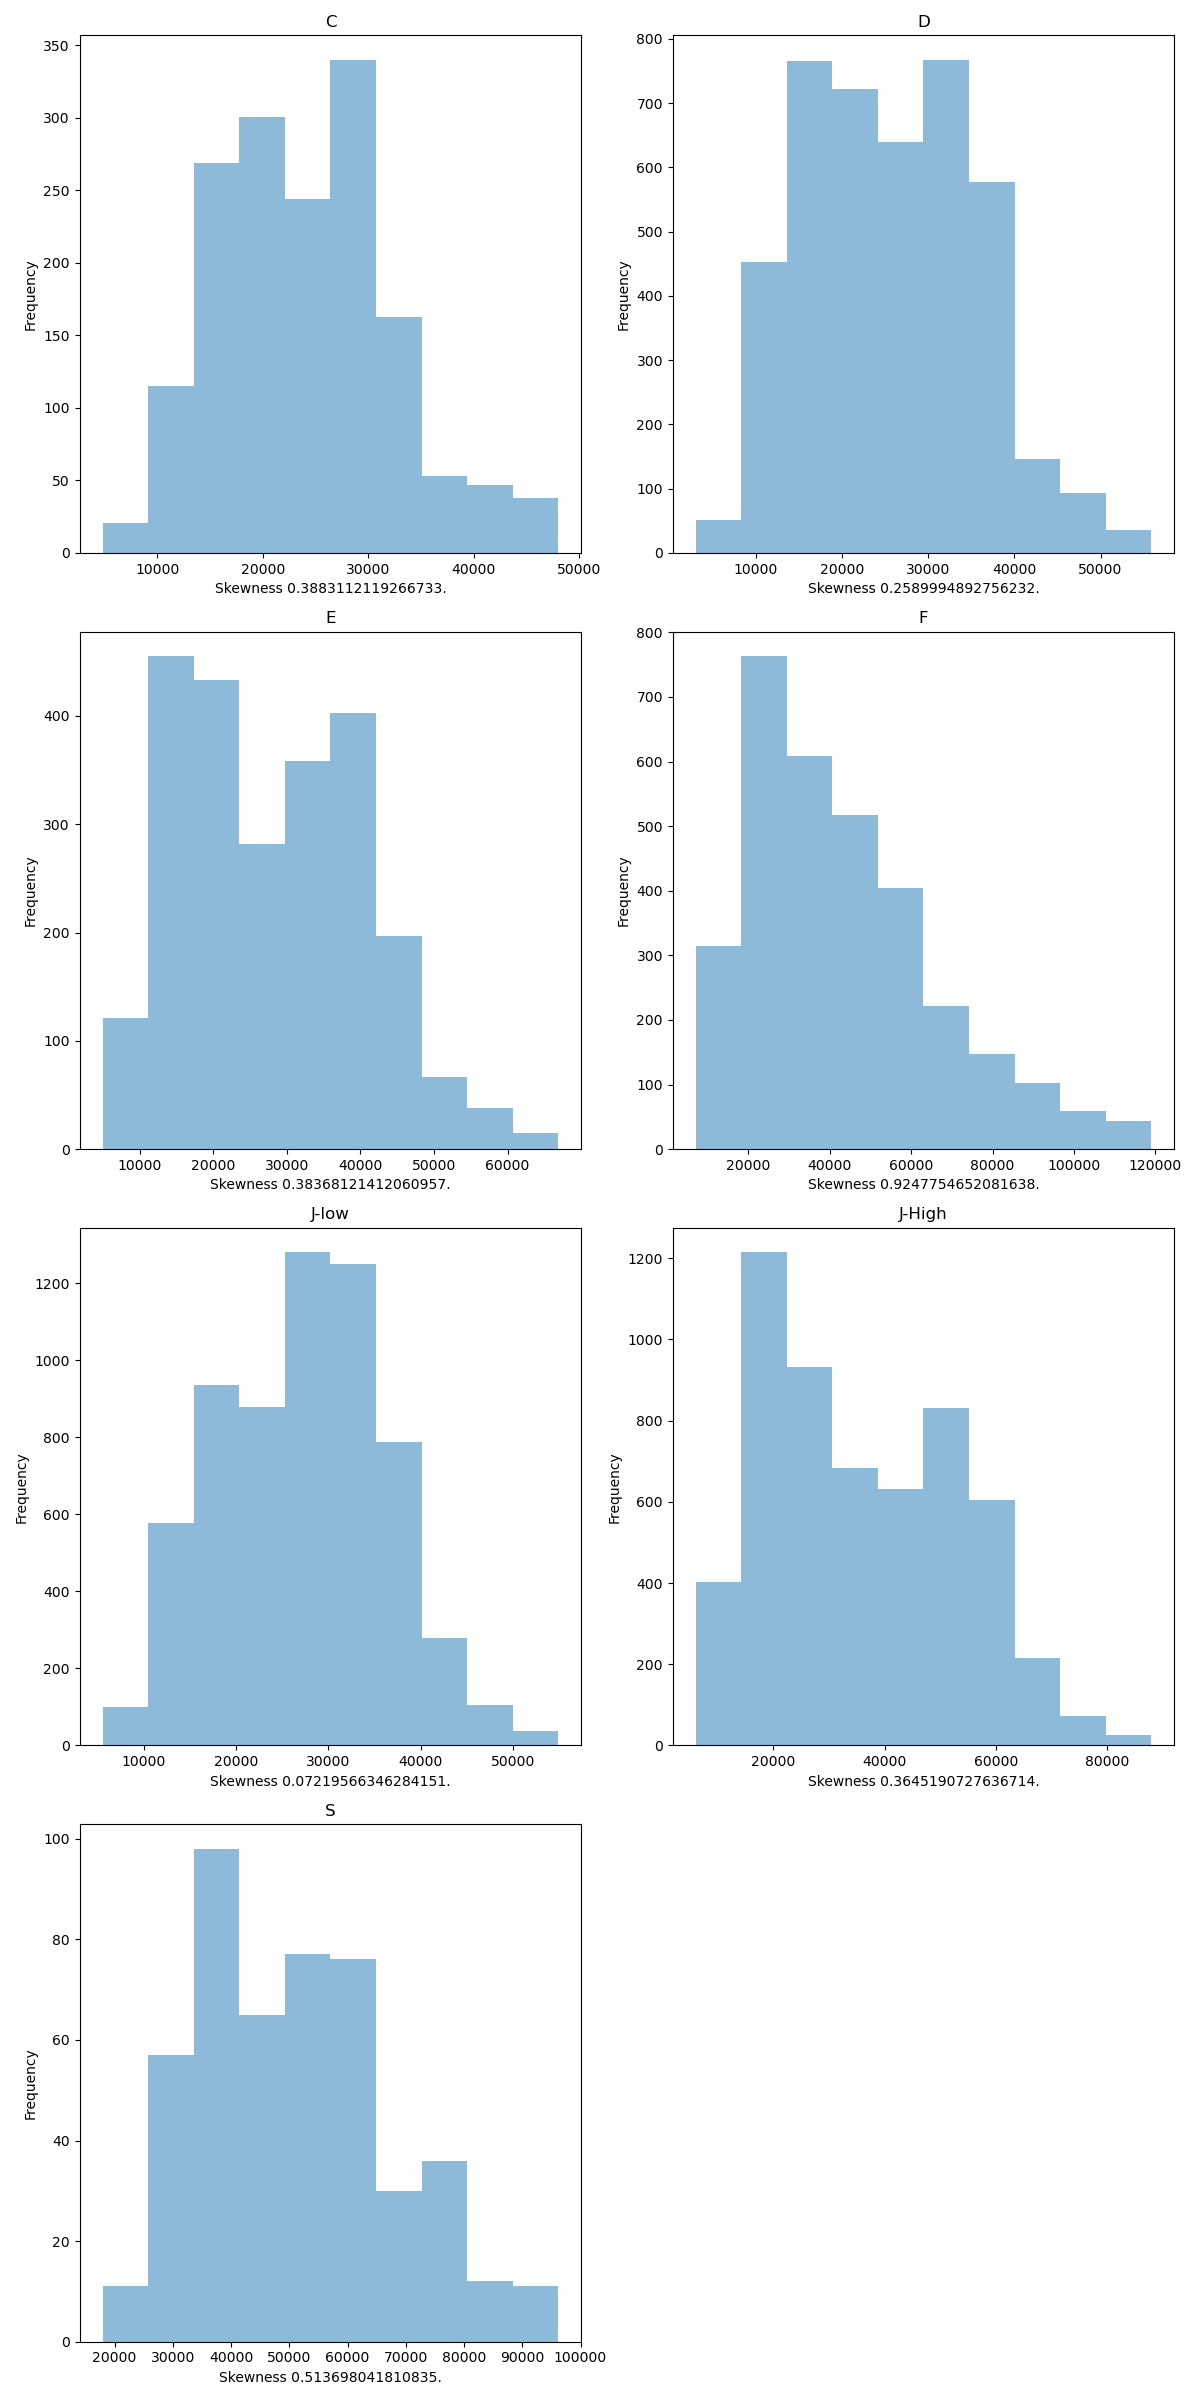

In [10]:
segments = cars["segment"].unique()  
outliers = calculate_segment_outliers(cars)

num_segments = len(segments)
num_rows = num_segments // 2 + num_segments % 2 

fig, axs = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
axs = axs.flatten()

# Plot histogram for each segment
for i, segment in enumerate(segments):
    segment_data = cars[(cars["segment"] == segment) & (cars["price"] < outliers[segment])]  

    # Determine the subplot index
    subplot_index = i % (num_rows * 2)

    axs[subplot_index].hist(segment_data["price"], bins=10, alpha=0.5)
    axs[subplot_index].set_xlabel(f"Skewness {segment_data['price'].skew()}.")
    axs[subplot_index].set_ylabel("Frequency")
    axs[subplot_index].set_title(segment)

# Remove any unused subplots
for j in range(i + 1, num_rows * 2):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Correlation 

#### The most correlated feature with price is mileage and it is of course negatively correlated, as we can safely assume without even seeing the numbers that the more mileage car has the cheaper it gets. It isn't super strong correlation and it  probably has to be so correlated anyway, so I am not changing or dropping any values. At least at this stage.

<IPython.core.display.Javascript object>


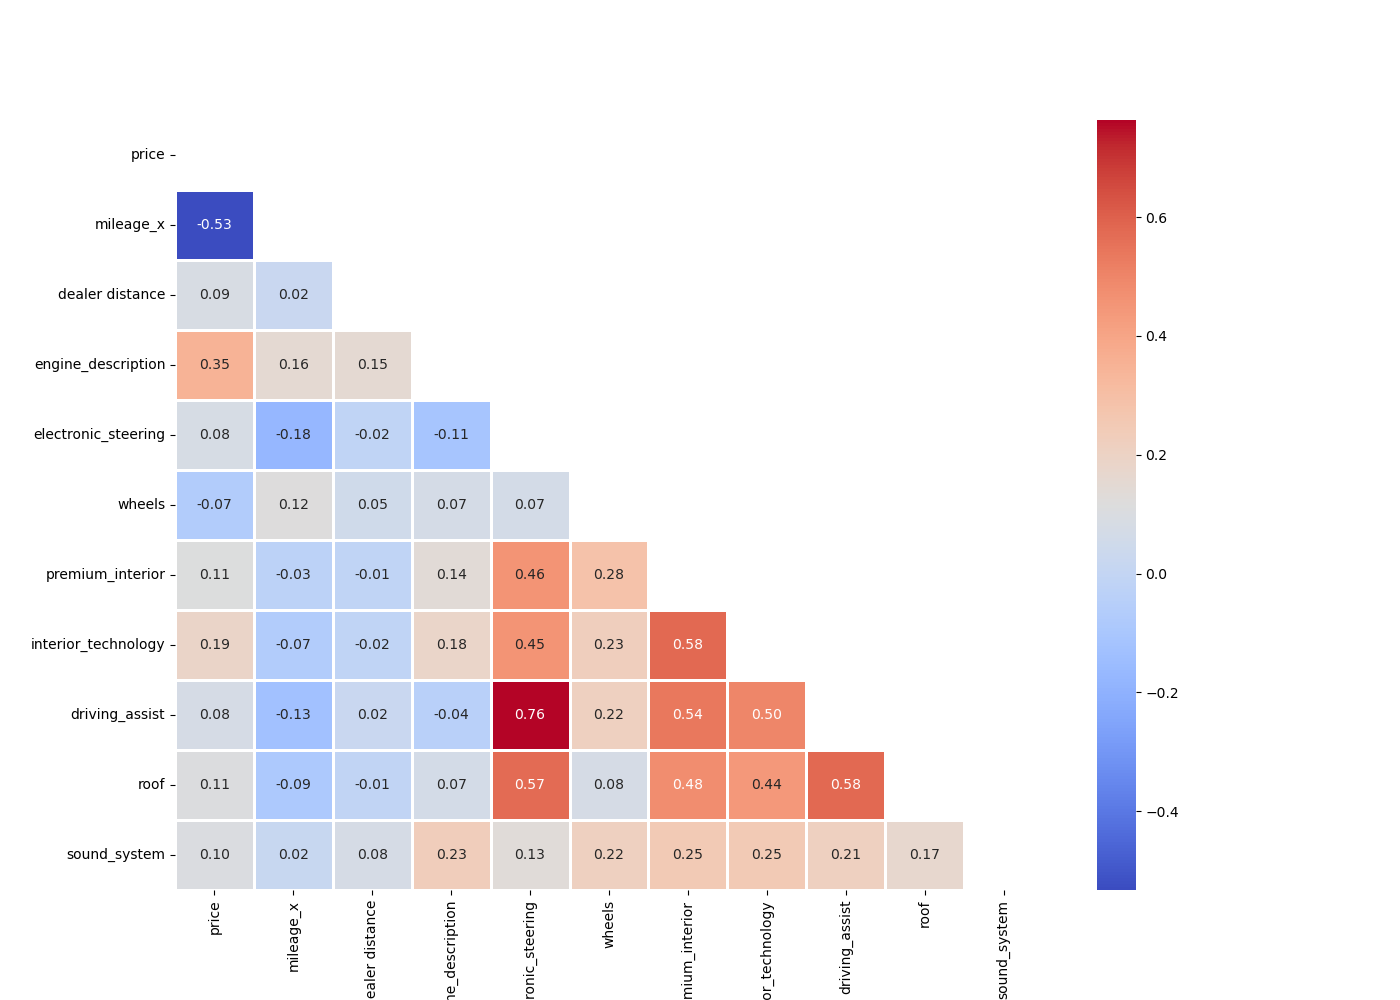

In [11]:
cars_numerical = cars.select_dtypes("number").columns
matrix = np.triu(cars[cars_numerical].corr())
fix, ax = plt.subplots(figsize=(14,10))
sns.heatmap(cars[cars_numerical].corr(),
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            linewidths=1,
            mask=matrix,
            ax=ax);

### Categorical variables

In [96]:
cars_categorical = cars.select_dtypes("object").columns
cars_categorical = cars_categorical.drop(["model", "exterior_colour"]) # dropping since we already have "segment" column

In [13]:
cars[cars_categorical].head()

,year,drive_type,exterior_colour,segment
0,2015,2 wheel drive - front,black,C
1,2015,All wheel drive,red,C
2,2020,All wheel drive,gray,C
3,2016,All wheel drive,black,C
4,2019,All wheel drive,white,C


#### Year and Price

#### No surprises here :-) 

#### Since price tends to increase each year I will make year a numerical variable, but normalise the values by scaling.

<IPython.core.display.Javascript object>


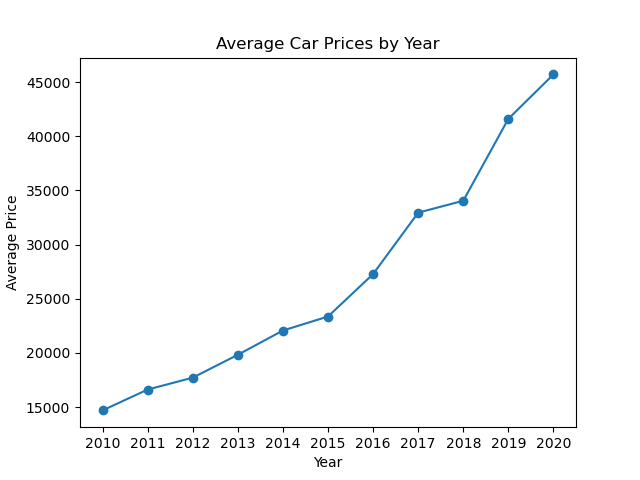

In [14]:
year_price = cars.groupby("year")["price"].mean().sort_values()

plt.plot(year_price.index, year_price.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.title("Average Car Prices by Year")
plt.show()

In [41]:
# Scaling the year variables
scaler = MinMaxScaler()
cars["year"] = scaler.fit_transform(cars["year"].values.reshape(-1, 1))

In [69]:
cars["engine_description"] = scaler.fit_transform(cars["engine_description"].values.reshape(-1, 1))

#### Below looks unusual at first sight since the biggest engine car may be perceived as the most expensive one too. The most expensive cars are for engine 5.2L, then after big gap 6.0L and 4.0L, then the 6.6L.

#### The reason for that is that the 5.2L engines are for R8 which has the most expensive cars in the list, the 6.6L is only for 7-series which are somewhere lower on the list.

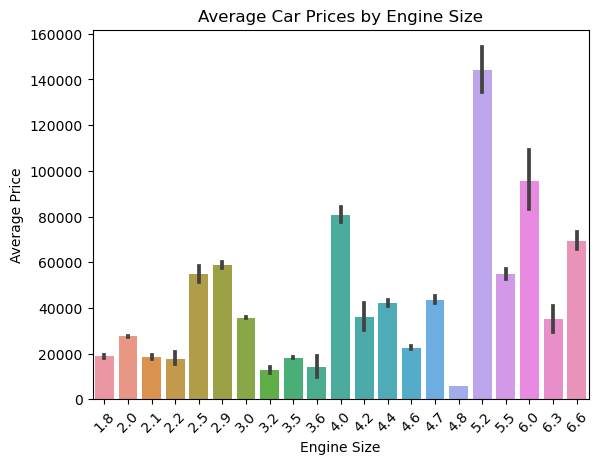

In [19]:
engine_price = cars.groupby("engine_description")["price"].mean().sort_values()

sns.barplot(cars, x="engine_description", y="price", )
plt.xlabel("Engine Size")
plt.ylabel("Average Price")
plt.title("Average Car Prices by Engine Size")
plt.xticks(rotation=45)
plt.show()

In [95]:
# Creating new dataframe that has no outliers
cars_without_outliers = cars.copy()
outliers = calculate_segment_outliers(cars_without_outliers)

for segment, prices in outliers.items():
    rows_to_remove = cars_without_outliers[(cars_without_outliers["segment"] == segment) & (cars_without_outliers["price"] >= prices)].index
    cars_without_outliers = cars_without_outliers.drop(rows_to_remove)

#### Now it looks much better. 5.2L is still higher, but without that huge difference as earlier.

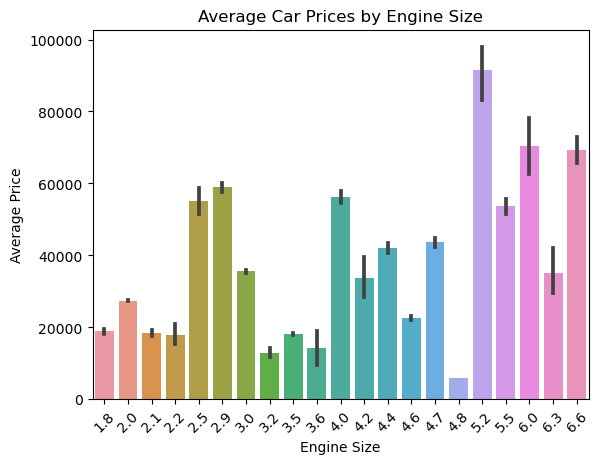

In [21]:
engine_price = cars_without_outliers.groupby("engine_description")["price"].mean().sort_values()

sns.barplot(cars_without_outliers, x="engine_description", y="price")
plt.xlabel("Engine Size")
plt.ylabel("Average Price")
plt.title("Average Car Prices by Engine Size")
plt.xticks(rotation=45)
plt.show()

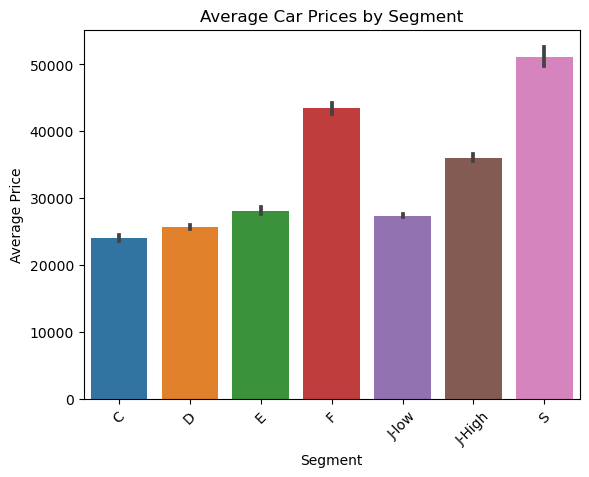

In [23]:
engine_price = cars_without_outliers.groupby("segment")["price"].mean().sort_values()

sns.barplot(cars_without_outliers, x="segment", y="price")
plt.xlabel("Segment")
plt.ylabel("Average Price")
plt.title("Average Car Prices by Segment")
plt.xticks(rotation=45)
plt.show()

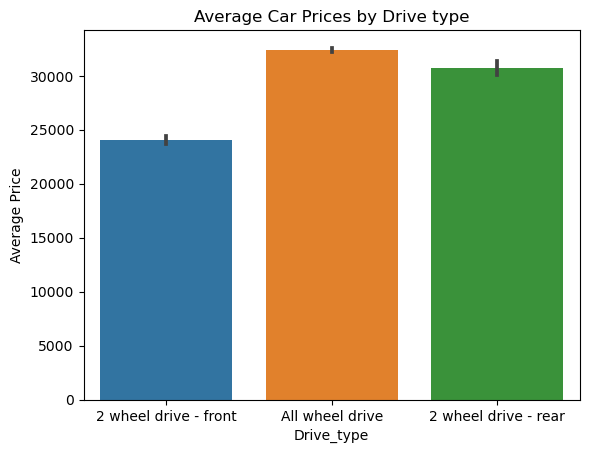

In [24]:
engine_price = cars_without_outliers.groupby("drive_type")["price"].mean().sort_values()

sns.barplot(cars_without_outliers, x="drive_type", y="price")
plt.xlabel("Drive_type")
plt.ylabel("Average Price")
plt.title("Average Car Prices by Drive type")
plt.show()

## Data Preparation

#### Creating dummy variables for the categories

In [97]:
cars_without_outliers = cars_without_outliers.drop("exterior_colour", axis=1)
dummy_variables = pd.get_dummies(cars_without_outliers[cars_categorical])
cars_without_outliers = pd.concat([cars_without_outliers, dummy_variables], axis=1)

#### Correlation one last time with all variables converted

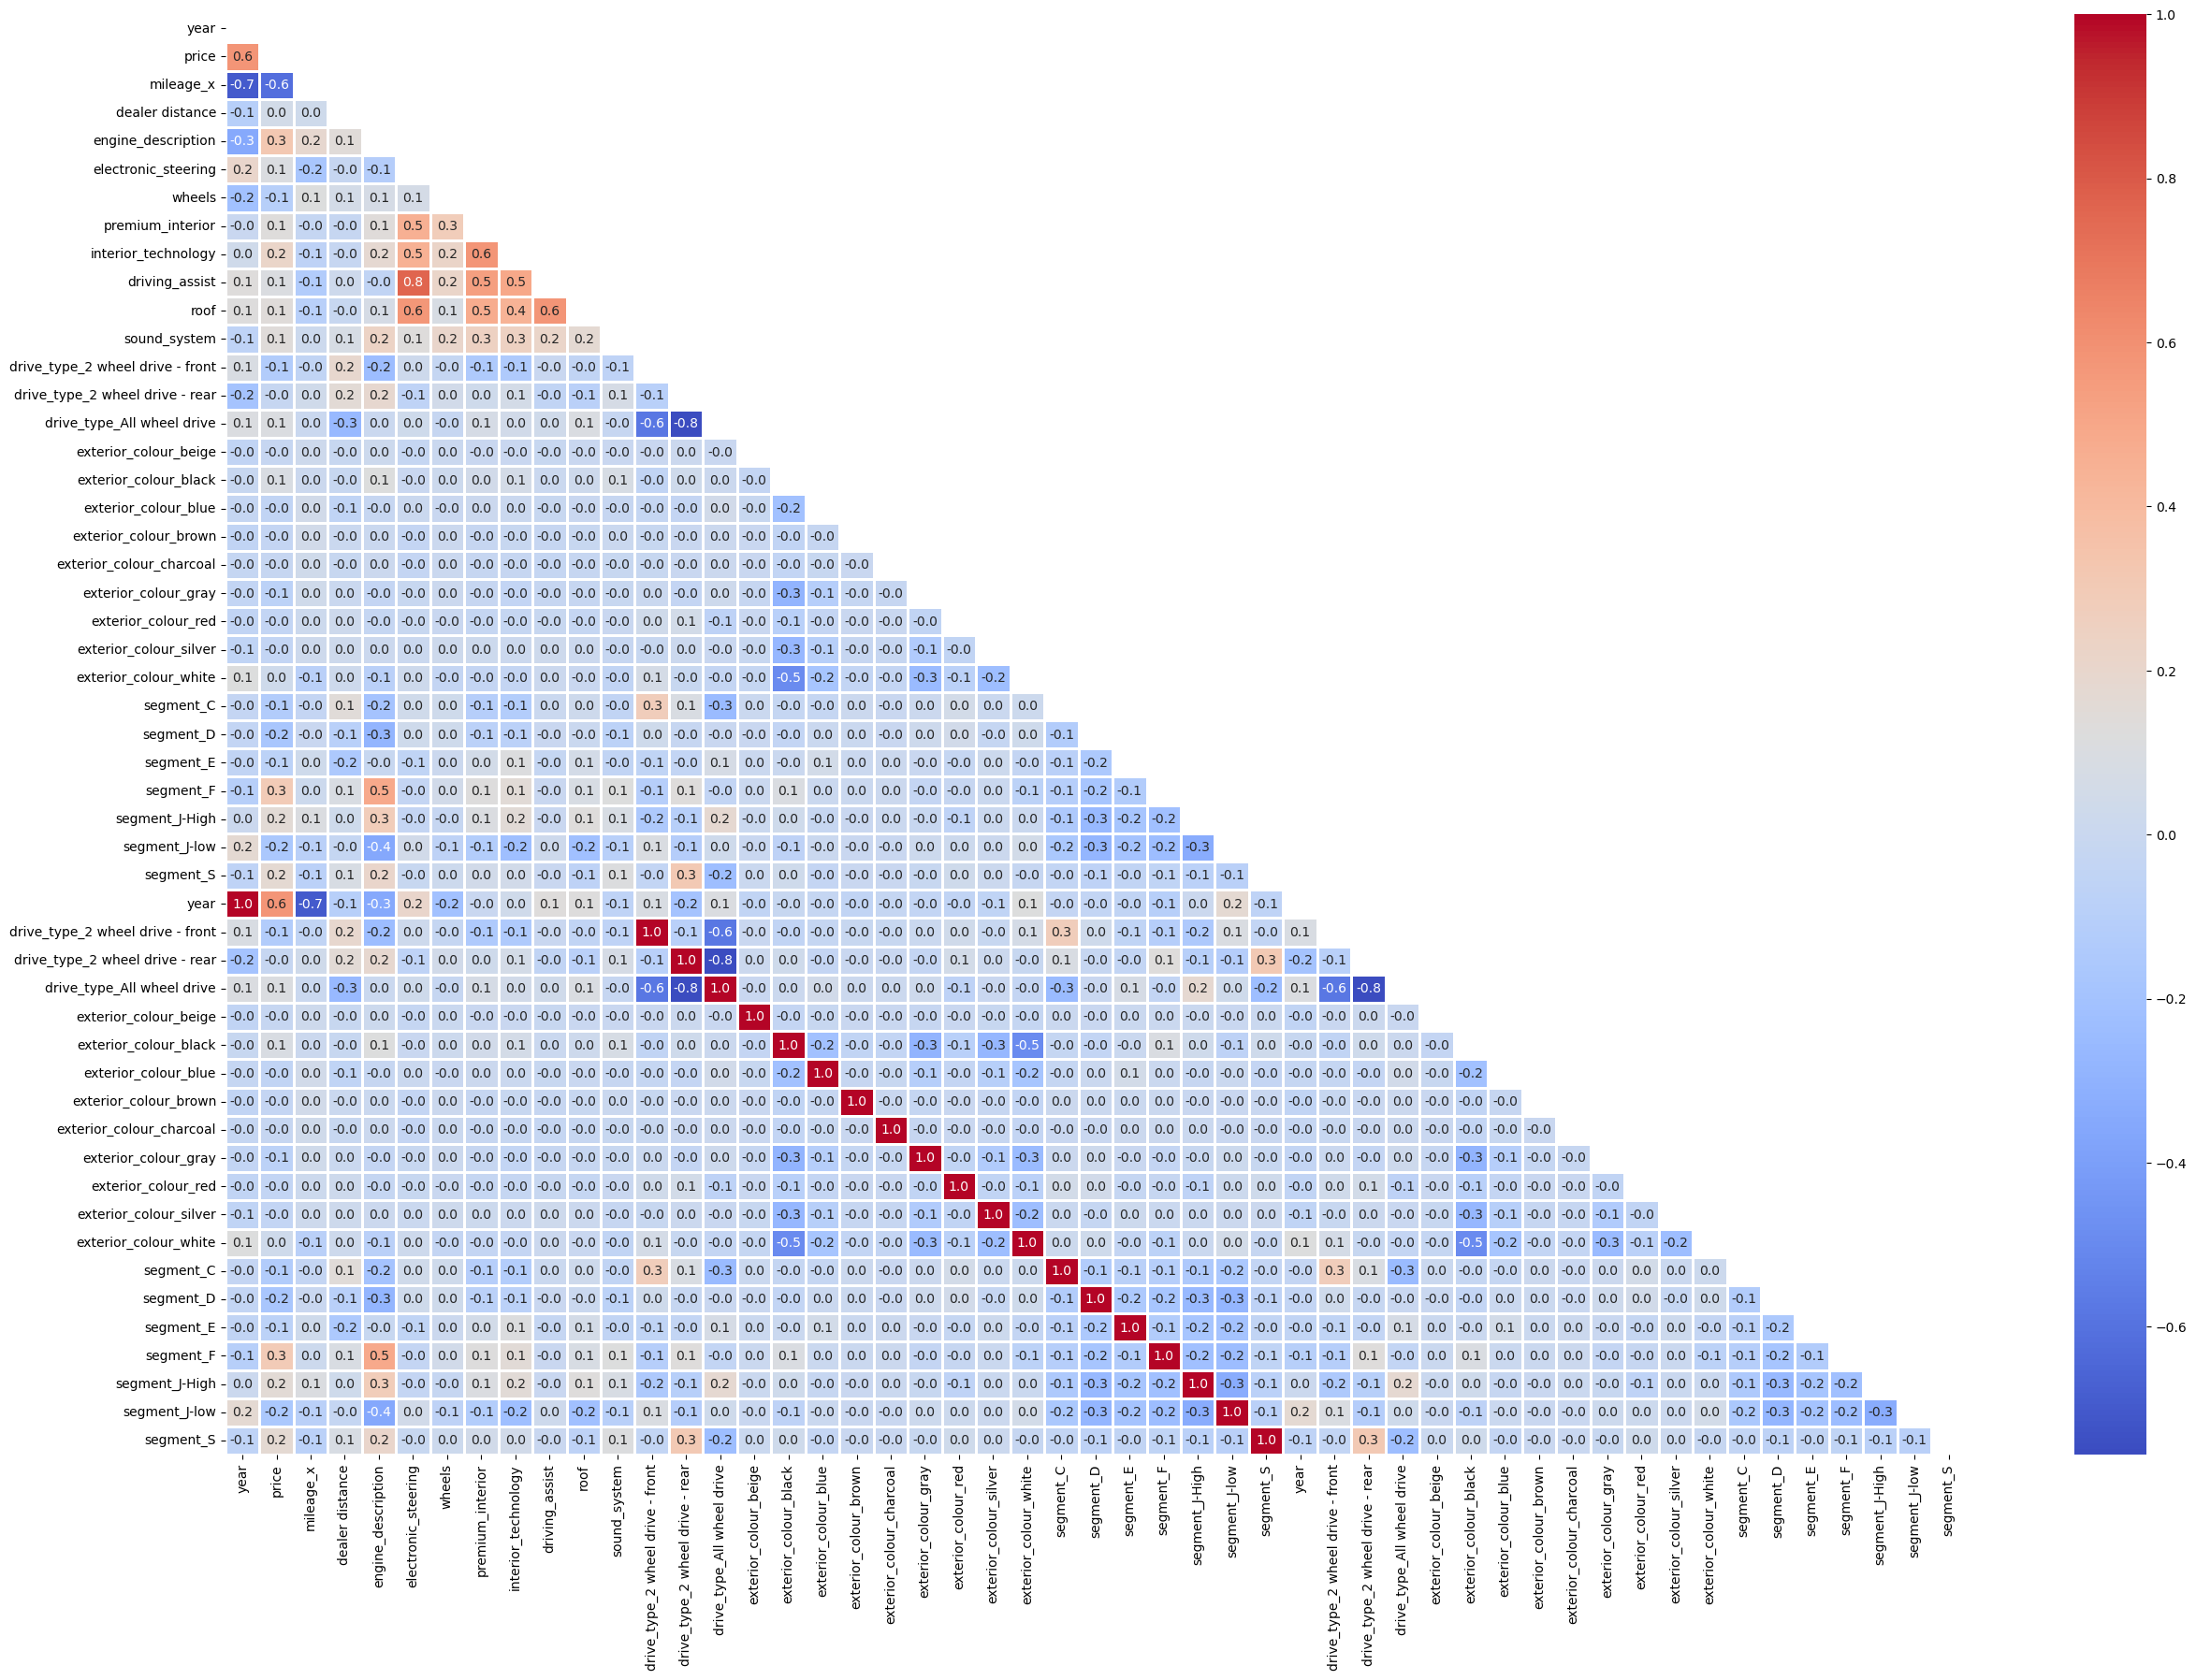

In [88]:
matrix = np.triu(cars_without_outliers.drop(["model", "drive_type", "exterior_colour", "segment"], axis=1).corr())
fix, ax = plt.subplots(figsize=(30,20))
sns.heatmap(cars_without_outliers.drop(["model", "drive_type", "exterior_colour", "segment"], axis=1).corr(),
            annot=True,
            fmt=".1f",
            cmap="coolwarm",
            linewidths=1,
            mask=matrix,
            ax=ax);

## Splitting the Data into Training and Testing Datasets

In [98]:
cars_without_outliers = cars_without_outliers.loc[:, ~cars_without_outliers.columns.duplicated()]

cars_without_outliers

,model,year,price,mileage_x,dealer distance,engine_description,drive_type,electronic_steering,wheels,premium_interior,...,drive_type_2 wheel drive - front,drive_type_2 wheel drive - rear,drive_type_All wheel drive,segment_C,segment_D,segment_E,segment_F,segment_J-High,segment_J-low,segment_S
0,A3,0.5,14995,39079,1,0.000000,2 wheel drive - front,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,A3,0.5,19995,48185,1,0.041667,All wheel drive,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,A3,1.0,33950,17550,30,0.041667,All wheel drive,0,1,1,...,0,0,1,1,0,0,0,0,0,0
3,A3,0.6,12680,97407,4,0.041667,All wheel drive,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,A3,0.9,20067,50833,5,0.041667,All wheel drive,1,0,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24112,SLK-Class,0.6,27586,48209,2528,0.354167,2 wheel drive - rear,0,0,0,...,0,1,0,0,1,0,0,0,0,0
24113,SLK-Class,0.4,18955,96595,2541,0.000000,2 wheel drive - rear,0,0,0,...,0,1,0,0,1,0,0,0,0,0
24114,SLK-Class,0.2,16588,103010,2552,0.354167,2 wheel drive - rear,0,0,0,...,0,1,0,0,1,0,0,0,0,0
24115,SLK-Class,0.3,19081,79128,2554,0.000000,2 wheel drive - rear,1,0,0,...,0,1,0,0,1,0,0,0,0,0


In [100]:
X = cars_without_outliers.drop(["model", "price", "drive_type", "segment", "dealer distance"], axis=1) # I do not want "model" as I already have "segment"
y = cars_without_outliers["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18965, 20), (4742, 20), (18965,), (4742,))

# Building a model

#### I will start with fitting the baseline model - Linear Regression.

#### Then I will use Lasso, KNeighbors, ElasticNet and RandomForest
#### At the end I will check the XGBoost Regression if I will no be happy with the outcome yet

## Models explained: 
This is just for my personal benefit to imprint it better in my memory

#### 1. Linear Regression. 
Assumes linear relationship between the features and the target variable. It shouldn't perform too well with this data, as there are weak correlations between many variables and we also have a lot of categorical variables. 
#### 2. Lasso. 
Linear regression model that incorporates regularisation to improve the performance and aid the feature selection. It adds the L1 penalty to the Least Squares that reduces impact of the coefficients closely to 0. e.g. if I have a lot of categorical variables especially with low correlation they may not impact the price that much, so they will be dropped.
Cons of Lasso is that it may introduce bias by shrinking too many coefficients to 0.
It similarly assumes linear relationships between predictors and the target variables. 
#### 3. ElasticNet.
Combination of Lasso and Ridge. It incorporates both L1 and L2 penalties. I will try it because it is useful for high number of features and it seems that some of the features are strongly correlated between each other (even if they are not correlated strongly with the Price). 
#### 4. KNeighbors.
Non-parametric algorithm that is used for classification and regression. It makes predictions based on similarities between data points. It predicts the target variable of a new data point by finding the K nearest neighbors from the training data. K is the number of neighbors considered. 
It is suitable for problems when local patterns or similarities are important. It is good when there are not a lot of non-linear relationships and without strong assumptions about the data. 
#### 5. Random Forest Regressor.
Enseble learning method based on decision trees. It takes multiple trees to make predictions. It is very flexible and has good predictive performance in wide range of scenarios. 
It employs the Bagging (Bootstrap Aggregating) technique that combines the predictions of multiple decision trees to make the final prediction. Each tree in the forest independently predicts the target variable and the final prediction is the average of individual tree predictions. 
It is capable of handling non-linear relationships. It is known for it's capability for handling high-dimensional, complex and noisy datasets.
#### 6. Gradient Boosting & XGBoost.
It combines multiple weak models (typically decision trees) in a sequential manner. It is a form of ensemble that each new model (tree) is trained to correct the errors made by previous models. They are added to the ensemble iteratively. 

In [101]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print(f"Linear Regression. RMSE score: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}.\
    R-Squared: {round(r2_score(y_test, y_pred), 3)}")

Linear Regression. RMSE score: 8072.96.    R-Squared: 0.74


In [102]:
# Remaining models

models = {
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "KNeighbors": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
    r2 = round(r2_score(y_test, y_pred), 3)
    
    print(f"{name}: RMSE: {rmse}. R-Squared: {r2}.")

Lasso: RMSE: 8072.74. R-Squared: 0.74.
ElasticNet: RMSE: 10944.4. R-Squared: 0.522.
KNeighbors: RMSE: 12984.16. R-Squared: 0.328.
Random Forest: RMSE: 5435.9. R-Squared: 0.882.
Gradient Boosting Regressor: RMSE: 5798.2. R-Squared: 0.866.
XGBoost: RMSE: 5195.2. R-Squared: 0.892.


#### Random Forest, Gradient Boosting Regressor and XGBoost did the best job. All very vlose to 0.9 R-Squared.

##### P.S. It is good that you can't go to jail for picking wrong model, because if Police will see the KNeighbors score I will be definitely on my way to Shawshank State Prison lol 

# Hyperparameter tuning

In [103]:
# Function to evaluate results for any model
def evaluation(best_grid, X_test, y_test):
    y_pred = best_grid.predict(X_test)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
    r2 = round(r2_score(y_test, y_pred), 3)
    
    print(f"RMSE: {rmse}. R-Squared: {r2}.")

### Random Forest Regressor

In [80]:
%%time
param_grid_rf = {
    "bootstrap": [True],
    "max_depth": [None],
    "max_features": [10],
    "min_samples_leaf": [1, 2],
    "min_samples_split": [4, 6, 8],
    "n_estimators": [250, 375, 500]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
CPU times: total: 15.6 s
Wall time: 1min 38s


{'bootstrap': True,
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 500}

In [81]:
best_grid_rf = grid_search.best_estimator_
evaluation(best_grid_rf, X_test, y_test)

RMSE: 5167.3. R-Squared: 0.894.


### Gradient Boosting Regressor

In [79]:
%%time
param_grid_gb = {
    "learning_rate": [0.1],
    "max_depth": [5],
    "max_features": ["auto"],
    "min_samples_leaf": [4],
    "min_samples_split": [12, 15],
    "n_estimators": [350, 400]
}
gb = GradientBoostingRegressor()

grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, n_jobs=-1, verbose=2)
grid_search_gb.fit(X_train, y_train)
grid_search_gb.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: total: 11.7 s
Wall time: 37.2 s


{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 350}

In [82]:
best_grid_gb = grid_search_gb.best_estimator_
evaluation(best_grid_gb, X_test, y_test)

RMSE: 5150.57. R-Squared: 0.894.


### XGBoost

In [104]:
%%time

xgb = XGBRegressor(colsample_bytree=0.5,
                     gamma=0,
                     learning_rate=0.01,
                     max_depth=10,
                     n_estimators=1000,
                     reg_alpha=0,
                     reg_lambda=1,
                     subsample=0.5)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
r2 = round(r2_score(y_test, y_pred), 3)

print(f"{name}: RMSE: {rmse}. R-Squared: {r2}.")

XGBoost: RMSE: 5063.31. R-Squared: 0.898.
CPU times: total: 1min 40s
Wall time: 9.06 s


# Results

### Random Forest 
RMSE: 5156.52. R-Squared: 0.894.

### Gradient Boosting Regressor
RMSE: 5150.57. R-Squared: 0.894.

### XGBoost
RMSE: 5063.31. R-Squared: 0.898.

In [105]:
feature_importances = xgb.feature_importances_
feature_names = X.columns
table = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

In [106]:
table

,Feature,Importance
2,engine_description,0.211018
16,segment_F,0.205811
17,segment_J-High,0.101188
19,segment_S,0.093897
0,year,0.086932
1,mileage_x,0.050208
18,segment_J-low,0.040016
14,segment_D,0.038834
13,segment_C,0.033126
15,segment_E,0.023222
